# Colour - HDRI - Examples: Merge from Raw Files

Through this example, some Canon EOS 5D Mark II *CR2* images will be merged together in order to create a single HDRI.

The following steps will be taken:

- Conversion of the *CR2* images to *DNG* files using [Adobe DNG Converter](http://www.adobe.com/support/downloads/detail.jsp?ftpID=5957).
- Conversion of the *DNG* files to intermediate demosaiced linear *Tiff* images using Dave Coffin's [dcraw](https://www.cybercom.net/~dcoffin/dcraw/).
- Creation of an image stack using *DNG* and intermediate *Tiff* images:
    - Reading of the *DNG* files *Exif* metadata using Phil Harvey's [ExifTool](http://www.sno.phy.queensu.ca/~phil/exiftool/).
    - Reading of the intermediate *Tiff* images using [OpenImageIO](http://openimageio.org/).
    - White balancing of the intermediate *Tiff* images.
    - Conversion of the intermediate *Tiff* images to *RGB* display colourspace.
- Merging of the image stack into a HDRI.
- Display of the final resulting HDRI.

> Note: Some steps can be performed using alternative methods or simplified, for instance the *DNG* conversion can be entirely avoided. The interest here is to retrieve the camera levels and the [Adobe DNG](https://helpx.adobe.com/photoshop/digital-negative.html) camera colour profiling data.

## CR2 Files Conversion to DNG and Intermediate Files

In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import os

import colour

from colour_hdri import (
    ROOT_RESOURCES_EXAMPLES,
    Image,
    ImageStack,
    camera_space_to_sRGB,
    convert_dng_files_to_intermediate_files,
    convert_raw_files_to_dng_files,
    filter_files,
    read_exif_tag,
    image_stack_to_HDRI,
    update_exif_tags,
    weighting_function_Debevec1997,
)
from colour_hdri.plotting import plot_HDRI_strip

logging.basicConfig(level=logging.INFO)


ROOT_RESOURCES = os.path.join(ROOT_RESOURCES_EXAMPLES, "frobisher_001")

colour.plotting.colour_style()

colour.utilities.describe_environment();

*                                                                             *
*   Interpreter :                                                             *
*       python : 3.10.8 (main, Oct 12 2022, 09:32:59) [Clang 14.0.0           *
*   (clang-1400.0.29.102)]                                                    *
*                                                                             *
*   colour-science.org :                                                      *
*       colour : 0.4.1                                                        *
*       colour-hdri : v0.1.8-156-g0bc7147                                     *
*                                                                             *
*   Runtime :                                                                 *
*       imageio : 2.22.1                                                      *
*       matplotlib : 3.6.1                                                    *
*       numpy : 1.23.4                  

In [2]:
RAW_FILES = filter_files(ROOT_RESOURCES, ("CR2",))

DNG_FILES = convert_raw_files_to_dng_files(RAW_FILES, ROOT_RESOURCES)

XYZ_TO_CAMERA_SPACE_MATRIX = colour.utilities.as_float_array(
    [float(M_c) for M_c in read_exif_tag(DNG_FILES[-2], "ColorMatrix2").split()]
).reshape((3, 3))

# In order to avoid artefacts, white balancing should be peformed before
# demosaicing thus we need to pass appropriate gains to *dcraw*.
WHITE_BALANCE_MULTIPLIERS = colour.utilities.as_float_array(
    [float(M_c) for M_c in read_exif_tag(DNG_FILES[-2], "AsShotNeutral").split()]
)

WHITE_BALANCE_MULTIPLIERS = 1 / WHITE_BALANCE_MULTIPLIERS

RAW_CONVERTER_ARGUMENTS = (
    '-t 0 -H 3 -r {0} {1} {2} {1} -4 -q 3 -o 0 -T "{{raw_file}}"'.format(
        *WHITE_BALANCE_MULTIPLIERS
    )
)

INTERMEDIATE_FILES = convert_dng_files_to_intermediate_files(
    DNG_FILES,
    ROOT_RESOURCES,
    raw_converter_arguments=RAW_CONVERTER_ARGUMENTS,
)

update_exif_tags(zip(DNG_FILES, INTERMEDIATE_FILES))

INFO:root:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.CR2" file to "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.dng" file.
*** GPU Warning: GPU3 disabled via cr_config at init time. ***
INFO:root:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2599.CR2" file to "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2599.dng" file.
*** GPU Warning: GPU3 disabled via cr_config at init time. ***
INFO:root:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2600.CR2" file to "/Users/kelsolaar/Documents/Development/

True

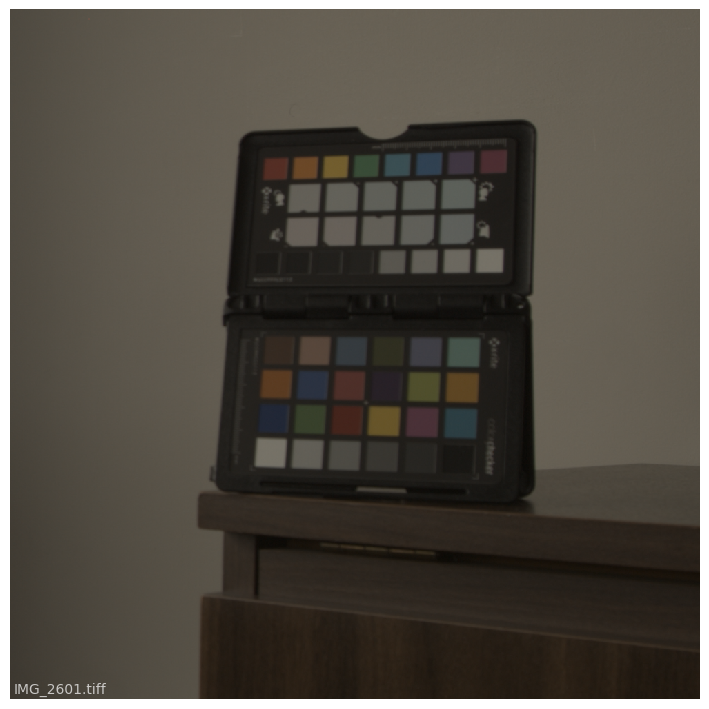

(<Figure size 1280x720 with 1 Axes>, <AxesSubplot: >)

In [3]:
colour.plotting.plot_image(
    colour.cctf_encoding(
        colour.read_image(str(INTERMEDIATE_FILES[-2]))[1400:2400, 3200:4200, ...]
    ),
    text_kwargs={"text": os.path.basename(INTERMEDIATE_FILES[-2])},
)

## HDRI Merge

In [4]:
def merge_from_raw_files(
    dng_files,
    output_directory,
    batch_size=5,
    weighting_function=weighting_function_Debevec1997,
):
    paths = []
    for dng_files in colour.utilities.batch(dng_files, batch_size):
        image_stack = ImageStack()
        for dng_file in dng_files:
            image = Image(dng_file)
            image.read_metadata()
            image.path = str(dng_file.replace("dng", "tiff"))
            image.read_data()

            image.data = camera_space_to_sRGB(
                image.data * np.max(WHITE_BALANCE_MULTIPLIERS),
                XYZ_TO_CAMERA_SPACE_MATRIX,
            )
            image_stack.append(image)

        path = os.path.join(
            output_directory,
            "{0}_{1}_MRF.{2}".format(
                os.path.splitext(os.path.basename(image_stack.path[0]))[0],
                batch_size,
                "exr",
            ),
        )
        paths.append(path)

        logging.info(f'Merging "{path}"...')
        logging.info(f'\tImage stack "F Number" (Exif): {image_stack.f_number}')
        logging.info(
            f'\tImage stack "Exposure Time" (Exif): {image_stack.exposure_time}'
        )
        logging.info(f'\tImage stack "ISO" (Exif): {image_stack.iso}')
        image = image_stack_to_HDRI(image_stack, weighting_function)

        logging.info(f'Writing "{path}"...')
        colour.write_image(image, path)

    return paths


PATHS = merge_from_raw_files(DNG_FILES, ROOT_RESOURCES)

INFO:root:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.dng" image metadata.
INFO:root:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.dng' image EXIF data.
INFO:root:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.tiff" image.
INFO:root:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2599.dng" image metadata.
INFO:root:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2599.dng' image EXIF data.
INFO:root:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/reso

## HDRI Display

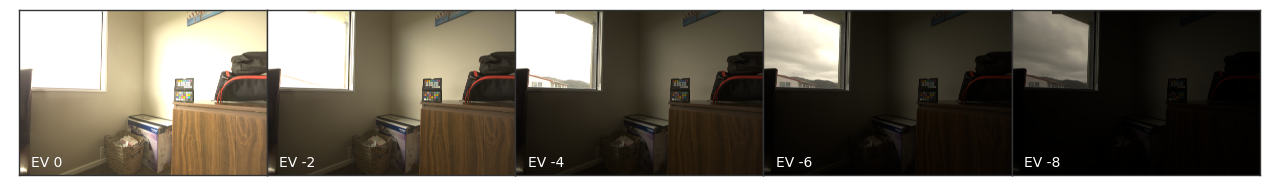

In [5]:
plot_HDRI_strip(colour.read_image(PATHS[0]));